In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path

from scipy.stats import  mannwhitneyu, ks_2samp

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "Kang_Lupus"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 

  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pt_S_v_S_tilde = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  df_top_2K = df_analy[ df_analy['rank_stat'] <= 2000 ]     
  x_cut = pd.qcut ( df_top_2K['nz_cells'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  y_cut = pd.qcut ( df_top_2K['abs_log_ratio'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  df_top_2K = df_top_2K.assign( Q_nz_cells = x_cut[0] )  
  df_top_2K = df_top_2K.assign( Q_instability = y_cut[0] )    
  pt = pv_table_noprint_margins ( df_top_2K, 'Q_instability', 'Q_nz_cells' )  
  pt_instability_v_nz_cells = ( pt.transpose() [[ 'Q4','Q3','Q2','Q1', 'Total']] ).transpose()
    
    
  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] <= 200 ].min()  
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
    
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label,  method_symbol.lower()  + ': instability' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 

  plot_ax ( df_analy, ax3, 'C', 'nz_cells', 'abs_log_ratio',  "$n_g$: nonzero cells" , method_symbol.lower()  + ': instability' ,yscale_log=False, line_slope='none' )
  

  y_min2, y_max2 = ax2.get_ylim()
  y_min3, y_max3 = ax3.get_ylim()
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max )    
  

  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return ( pt_S_v_S_tilde, pt_instability_v_nz_cells,  df_top_2K['abs_log_ratio'].values )

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_nz_cells = nru_dict['df_gene_stats'] [['nz_cells']]
print (  '\n\n df_nz_cells: ' )  
print (  '\n', df_nz_cells   )  


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
df_A_g['rank_stat'] = df_A_g['stat'].rank( ascending=False )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
df_L_g['rank_stat'] = df_L_g['stat'].rank( ascending=False )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
df_S_g['rank_stat'] = df_S_g['stat'].rank( ascending=False )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )



 df_nz_cells: 

                  nz_cells
ENSG00000244734      2432
ENSG00000188536       614
ENSG00000167996     26522
ENSG00000206172       380
ENSG00000087086     23321
...                   ...
ENSG00000136492        71
ENSG00000253593        50
ENSG00000172379        82
ENSG00000226004        73
ENSG00000123643        54

[10619 rows x 1 columns]


 df_A_g:  

                        stat  rank_stat
ENSG00000244734  583.983476        1.0
ENSG00000188536  170.301545        2.0
ENSG00000167996   94.267171        3.0
ENSG00000206172   93.234056        4.0
ENSG00000087086   82.854512        5.0
...                     ...        ...
ENSG00000136492    0.612331    10603.5
ENSG00000253593    0.612331    10603.5
ENSG00000172379    0.612331    10603.5
ENSG00000226004    0.612331    10603.5
ENSG00000123643    0.612331    10603.5

[10619 rows x 2 columns]


 df_L_g:  

                       stat  rank_stat
ENSG00000244734  79.810010        1.0
ENSG00000188536  64.410016        2.0
ENSG0


  A_g


 df_complementary_stats_Ag

                           0           1
ENSG00000244734  588.145207  501.531965
ENSG00000188536  169.392362  153.041075
ENSG00000167996   92.837921   93.239858
ENSG00000206172   91.970705   90.978825
ENSG00000087086   81.418673   80.393600
...                     ...         ...
ENSG00000162433    0.636398    0.720220
ENSG00000182197    0.636398    0.675587
ENSG00000029153    0.636398    0.623028
ENSG00000160883    0.636398    0.700949
ENSG00000158186    0.636398    0.623028

[9091 rows x 2 columns]


 genes rank_stat_200:  2.4408916460654053


 Table 3

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        2     25       2        1        0         0      0     30
51-100       0      1      45        3        1         0      0     50
101-200      0      2       3       87  

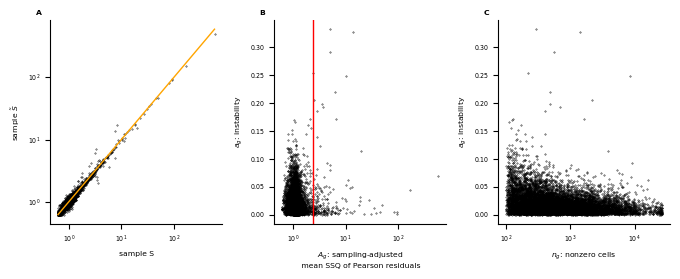

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_stats_Ag = pd.concat ( [ df_nz_cells, df_A_g ], axis=1 ) 
df_stats_Ag = df_stats_Ag.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Ag = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn )  

print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 4' )
print ( '\n', pt_instability_v_nz_cells ) 


  L_g


 df_complementary_stats_Lg

                          0          1
ENSEMBL_ID                           
ENSG00000087086  50.711936  51.099089
ENSG00000167996  42.481003  42.322134
ENSG00000169245  40.903462  40.700295
ENSG00000187608  38.979586  38.098613
ENSG00000244734  37.104743  46.446606
...                    ...        ...
ENSG00000179331   0.679744   0.886626
ENSG00000079215   0.677357   0.889302
ENSG00000116991   0.665157   0.758688
ENSG00000241399   0.650771   0.716066
ENSG00000113494   0.636110   0.653710

[9091 rows x 2 columns]


 genes rank_stat_200:  2.7097638850234116


 Table 6

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        1     25       2        2        0         0      0     30
51-100       1      3      41        5        0         0      0     50
101-200      0      0     

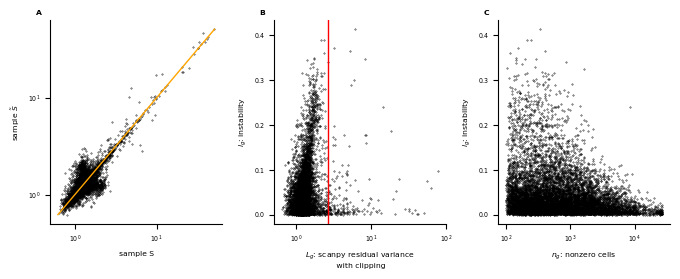

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_stats_Lg = pd.concat ( [ df_nz_cells, df_L_g ], axis=1 ) 
df_stats_Lg = df_stats_Lg.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Lg = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 

print ( '\n\n Table 6' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 7' )
print ( '\n', pt_instability_v_nz_cells ) 


  S_g


 df_complementary_stats_Sg

                         0         1
gene_vector                        
ENSG00000000419  1.119078  1.028459
ENSG00000000457  0.305840  0.256165
ENSG00000000938  0.828076  0.835764
ENSG00000001036  0.412737  0.410825
ENSG00000001084  0.258487  0.279365
...                   ...       ...
ENSG00000273272  0.528022  0.467131
ENSG00000273319  0.166517  0.155134
ENSG00000273341  0.546378  0.570863
ENSG00000273344  0.572827  0.846323
ENSG00000273445  1.019414  1.062243

[9091 rows x 2 columns]


 genes rank_stat_200:  1.803969739579009


 Table 9

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        19      1       0        0        0         0      0     20
21-50        1     26       3        0        0         0      0     30
51-100       0      3      39        6        1         0      1     50
101-200      0      0       7       70       20      

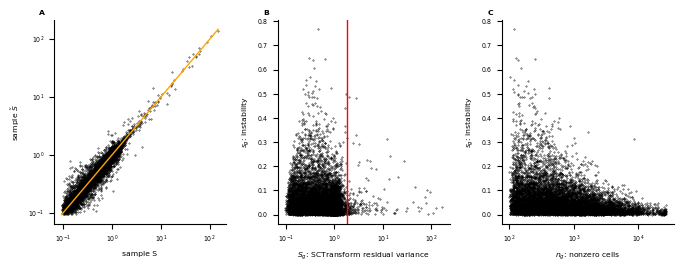

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_stats_Sg = pd.concat ( [ df_nz_cells, df_S_g ], axis=1 ) 
df_stats_Sg = df_stats_Sg.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Sg = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 

print ( '\n\n Table 9' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 10' )
print ( '\n', pt_instability_v_nz_cells ) 

In [10]:
MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='less' )   

print ( ' one-sided tests \n ---------------  \n\n null: L_g = A_g,  alternative: L_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )


MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='less' )   

print ( '\n\n null: S_g = A_g,  alternative: S_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )

 one-sided tests 
 ---------------  

 null: L_g = A_g,  alternative: L_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  2590683.0      p =  3.0983242781184986e-162

 scipy.stats.ks_2samp:  
 statistic =  2590683.0      p =  2.3696573077731266e-172


 null: S_g = A_g,  alternative: S_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  2661350.0      p =  7.737422422606601e-100

 scipy.stats.ks_2samp:  
 statistic =  2661350.0      p =  1.106683821231655e-94
